In [1]:
from pprint import pprint as pp
from datetime import datetime, date, timedelta, timezone
import pandas as pd
import numpy as np
import os
import pytz
from collections import ChainMap, OrderedDict
from pwe.hyptest import ttest_1samp_,ttest_ind_
import pwe.pwetools as pwe
from pwe import charts,cme,ta
from pwe.analysis import Security
#pd.options.display.float_format = '{:,.2f}'.format

# pip install -U textblob
from textblob import TextBlob
import re

# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

import json 
import requests 
import backtrader as bt
import backtrader.analyzers as btanalyzers
#import qgrid
from pwe.cmc import binance
import pyfolio as pf
from time import time
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pathlib import Path
import csv
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from scrapy.exceptions import DropItem
from FiScrape.models import Article, Tag, db_connect, create_table, Topic, Source, Author, SnipBlob, Blob, SnipVader, Vader #  create_output_table
# from FiScrape.spiders.FiSpider import query
import logging

/Users/zenman618/opt/anaconda3/envs/pwepip/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



In [2]:
# from google.colab import files
# files.upload()

In [3]:
start_date = pwe.to_utc('2019-12-21')
print (start_date)

end_date = pytz.utc.localize(datetime.utcnow())
print (end_date)

Assuming naive datetime: 2019-12-21 00:00:00 is already in UTC and labelling it as such. Ensure this is correct.
2019-12-21 00:00:00+00:00
2021-09-28 10:12:14.518682+00:00


In [4]:
# username=cme_user
# password=cme_pass

# ## Settings for reading most recent local data:
# brr, brti_1h = cme.get_cme(username=username, password=password, dataset='CRYPTOCURRENCY',hzn='any',
#                  dir='Users/zenman618/Documents/git_packages/VisualStudioGit/pwe_analysis/csv_files/CME/Crypto',
# index_col='DateTime', limit=2, processes=1, resample=True, interval='1h', symbols=['BRR', 'BRTI'])
# brti_1h.tail()

In [93]:
symbol = 'BTCUSDT'
interval='1h'

# Enter the time in GMT, with naive format. Binance API is inconsistent and doesn't use TZ aware dates for this endpoint. It imterprets dates as your local tz and returns naive GMT.
btc_usdt = binance(symbol='BTCUSDT',start_date=start_date,end_date=end_date, interval=interval, your_tz="Asia/Dubai") # "2021-09-16 23:00:00"
btc_usdt = btc_usdt.drop(columns=['Dt_Asia_Dubai'])
btc_usdt


Security: BTCUSDT
Interval: 1h

Checking if a file for this ticker with the same start and end dates exists...
No CSV: /Users/zenman618/Documents/git_packages/VisualStudioGit/FiScrape/csv_files/Binance/BTCUSDT_1h_2019-12-21_00,00,00_2021-09-28_10,12,14.csv found. Downloading data from API
(15451, 5)
Checking if csv_files/Binance directory exists...
csv_files/Binance folder already exists.
Saving as csv to: csv_files/Binance/BTCUSDT_1h_2019-12-21_00,00,00_2021-09-28_10,00,00.csv


,Open,High,Low,Close,Volume
DateTime,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363
...,...,...,...,...,...
2021-09-28 06:00:00+00:00,42413.07,42490.95,41855.99,42214.35,1739.578560
2021-09-28 07:00:00+00:00,42214.35,42303.34,41650.00,41775.25,2331.773060
2021-09-28 08:00:00+00:00,41777.79,42081.74,41514.12,41844.31,3176.933560


In [13]:
# bin_vs_brti = btc_usdt.join(brti_1h, lsuffix="_Bin", rsuffix="_BRTI")

# charts.pwe_line_chart(bin_vs_brti,columns=['Close_Bin', 'Close_BRTI'],start_date=start_date,end_date=end_date,kind='scatter',title='Binance BTCUSDT vs CME BRTI',
#                   ticker='BTCUSDT',yTitle='BTC/USD',asPlot=True,showlegend=False,theme='white',
#                  auto_start='2021-01-01',auto_end=None,connectgaps=False,annots=None,annot_col=None)

In [94]:
btc_usdt = btc_usdt.fillna(method="ffill")

btc_usdt.name = "btc_usdt"
btc_usdt = Security(btc_usdt)

trading_periods = 365
market_hours = 24
vol_window = 30
interval = 'hourly'

pwe.sort_index(btc_usdt.df)
pwe.split_datetime(btc_usdt.df,date=True,year=True,quarter=True,month=True,day=False,dow=True,time=True,hour=True)
btc_usdt.get_returns()
btc_usdt.get_vol(window=vol_window,trading_periods=trading_periods,interval=interval,market_hours=market_hours);
btc_usdt.YangZhang_estimator(window=vol_window, trading_periods=trading_periods,interval=interval,market_hours=market_hours);

btc_usdt_expirations, btc_usdt_last_fris_df, btc_usdt.df = pwe.get_exp_dates(btc_usdt.df, start=None, end=None, freq='D', time='15:00:00', exp_tz='London', expires='last_fri', name='CME Exp.')
btc_usdt_expirations, btc_usdt_last_fris_df, btc_usdt.df = pwe.get_exp_dates(btc_usdt.df, start=None, end=None, freq='h', time='15:00:00', exp_tz='London', expires='last_fri', name='CME Exp.')
pwe.expir_delta(btc_usdt.df, interval='h', expirations_df=btc_usdt_last_fris_df)
btc_usdt.df.drop(columns='DateTime', inplace=True)

nans = btc_usdt.df['Price_Returns'].isnull().value_counts()
nans

Searching for TZ...
Timezone: Europe/London

First expiration date: ('2019-12-27', 'CME Exp.')
Last expiration date: ('2021-09-24', 'CME Exp.')
Expiration dates in range: 22
Found expiration dates: 22
Missing expiration dates: 0
Searching for TZ...
Timezone: Europe/London

First Expiration_DateTime: ('2019-12-27 15:00:00', 'CME Exp.')
Last expiration date: ('2021-09-24 14:00:00', 'CME Exp.')
Expiration dates in range: 22
Expiration day datetimes in range: 22
Found expiration day datetimes: 22
Missing expiration day datetimes: 0


False    15450
True         1
Name: Price_Returns, dtype: int64

In [95]:
trading_periods = 365
market_hours = 24
vol_window = 30
interval = 'hourly'

btc_usdt.stats(trading_periods=trading_periods,interval=interval,market_hours=market_hours,vol_window=vol_window);



btc_usdt Return Stats:
Dates: 2019-12-21 00:00:00+00:00 - 2021-09-28 10:00:00+00:00
Periods: 15450 hours
Trading Periods: 365 days a year
Years: 1.76

Cumulative Returns: 483.32%

Arithmetic Mean Return: 0.015345%
Geometric Mean Return: 0.011415%

Median Return: 0.015554%

Annualaized Arithmetic Return: 283.49%
Annualized Geometric Return: 171.81%
 
Vol. of Period Returns: 0.888009%
Mean Volatility (30): 0.729135%
Mean YangZhang (30): 0.847489%

Annualized Vol: 83.11%
Annualized Mean Volatility (30): 68.24%
Annualized Mean YangZhang (30): 79.32%

Arithmetic Sharpe Ratio: 3.41
Geometric Sharpe Ratio: 2.07
 
Return Summary self:
count    15450.000000
mean         0.000153
std          0.008843
min         -0.182115
25%         -0.002965
50%          0.000156
75%          0.003392
max          0.173840
Name: Price_Returns, dtype: float64
Jarque-Bera: Jarque_beraResult(statistic=1622150.0672140853, pvalue=0.0)
Kurtosis: 53.18671821830096
Skew: -0.5334039466633747
######



In [96]:
df = btc_usdt.df

# df = df.join(brr, how='left')

ta.ama(df,price='Close', window=9,fast_period=6,slow_period=12,fillna=False)
ta.bol_bands(df,window=20,std=2,price='Close',fillna=False, lib=False, inputs=None)
ta.kalman_filter(df, price='Close', transition_matrices=[1], observation_matrices=[1], initial_state_mean=0, initial_state_covariance=1,
                    observation_covariance=1, transition_covariance=.01)

df['target'] = np.where(df['Price_Returns']>0, 1, np.where(df['Price_Returns']<0, -1, 0))
df

,Open,High,Low,Close,Volume,Date,Year,Quarter,Month,Day_of_Week,...,AMA_6_12,bb_bbh_2_20,bb_bbm_2_20,bb_bbl_2_20,bb_bbhi_2_20,bb_bbli_2_20,bb_bbw_2_20,bb_bbp_2_20,Kalman_Filter,target
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,3582.270000,0
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,4789.960132,-1
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5403.489302,1
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,5773.919558,-1
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363,2019-12-21,2019,4,12,5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,6022.853702,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28 06:00:00+00:00,42413.07,42490.95,41855.99,42214.35,1739.578560,2021-09-28,2021,3,9,1,...,42959.270402,43789.329529,42877.5760,41965.822471,0.0,0.0,4.252822,0.136291,42792.160964,-1
2021-09-28 07:00:00+00:00,42214.35,42303.34,41650.00,41775.25,2331.773060,2021-09-28,2021,3,9,1,...,42896.891222,43719.163631,42778.9540,41838.744369,0.0,1.0,4.395664,-0.033766,42695.427388,-1
2021-09-28 08:00:00+00:00,41777.79,42081.74,41514.12,41844.31,3176.933560,2021-09-28,2021,3,9,1,...,42862.408851,43649.277692,42693.9530,41738.628308,0.0,0.0,4.475222,0.055312,42614.464913,1


In [97]:
# df['bb_bbw_2_20'].value_counts()
df['bb_bbw_2_20'].isna().value_counts()

False    15432
True        19
Name: bb_bbw_2_20, dtype: int64

In [98]:
pwe.candle_close_dt(df, mins=59, secs=59)

# Add News Sentiment

In [99]:
from sqlalchemy import asc, desc, func
# con = 'sqlite:///FiScrape_01.db'
uri = 'sqlite:///FiScrape_01.db'
# from os import environ
# uri = environ.get('CONNECTION_STRING')
# from scrapy.utils.project import get_project_settings
# uri = get_project_settings().get("CONNECTION_STRING")
# self.engine = create_engine(db_uri, echo=True)

In [100]:
# engine = db_connect()
engine = create_engine(uri)
# create_table(engine)
Session = sessionmaker(bind=engine)
session = Session()
connection = engine.connect()
logging.info("****_NLP_Pipeline: database connected****")

# link ="https://www.ft.com/content/7200b459-265a-44fc-a31c-3843e4802f75"
# exist_article = session.query(Article).filter_by(article_link = link).first()
# #articles = session.query(Article).all()
# warnings.filterwarnings('ignore')

In [101]:
# articles = get_total_articles(session)
# pd.read_sql_query(sql, con, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None, dtype=None)
# df_arts = pd.read_sql(articles, uri, index_col='published_date', coerce_float=True, params=None, parse_dates='published_date',
#                     columns=None, chunksize=None)

In [102]:
from FiScrape.sql_tools import uri, get_snippet_sent

ft = get_snippet_sent(uri, pub_source='ft')
ft

,id,subjectivity,polarity,compound,negative,neutral,positive
published_date,,,,,,,
2021-09-27 11:13:53,1,0.705556,0.133333,-0.1531,0.099,0.791,0.110
2021-09-24 20:56:01,2,0.350000,-0.062500,0.2500,0.085,0.782,0.133
2021-09-25 08:00:25,3,0.550000,0.287500,0.7579,0.057,0.722,0.221
2021-09-27 08:23:54,4,0.275000,-0.100000,0.3818,0.043,0.838,0.118
2021-09-23 17:28:26,5,0.300000,-0.066667,0.0000,0.000,1.000,0.000
2021-09-24 13:51:19,6,0.375000,-0.041667,0.1027,0.000,0.960,0.040
2021-09-24 17:47:57,7,0.316667,0.183333,-0.2500,0.067,0.933,0.000
2021-09-23 07:14:13,8,0.636161,0.071875,-0.1027,0.045,0.955,0.000
2021-09-23 10:10:37,9,0.687500,0.237500,0.5423,0.036,0.840,0.125


In [103]:
ft = pwe.sort_index(ft)
ft = pwe.to_utc(ft)
ft.columns = ft.columns.str.capitalize()
ft

Assuming naive DateTime Index is already in UTC and labelling it as such. Ensure this is correct.


,Id,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
published_date,,,,,,,
2021-09-21 12:31:13+00:00,13,0.850000,0.100000,0.3612,0.038,0.885,0.078
2021-09-22 15:00:36+00:00,11,0.457143,0.104762,0.3400,0.000,0.934,0.066
2021-09-22 20:54:05+00:00,12,0.687500,0.237500,0.1280,0.040,0.907,0.054
2021-09-23 07:14:13+00:00,8,0.636161,0.071875,-0.1027,0.045,0.955,0.000
2021-09-23 10:10:37+00:00,9,0.687500,0.237500,0.5423,0.036,0.840,0.125
2021-09-23 17:12:23+00:00,10,0.687500,0.237500,0.1280,0.046,0.891,0.063
2021-09-23 17:28:26+00:00,5,0.300000,-0.066667,0.0000,0.000,1.000,0.000
2021-09-24 13:51:19+00:00,6,0.375000,-0.041667,0.1027,0.000,0.960,0.040
2021-09-24 17:47:57+00:00,7,0.316667,0.183333,-0.2500,0.067,0.933,0.000


In [104]:
# Hourly Sentiment
ft['Id'] = 1
ft = ft.rename(columns={'Id': 'Articles'})
interval  = '1H'
origin='start_day'
resamp_dict = {'Articles': 'sum', 'Subjectivity': 'mean', 'Polarity': 'mean', 'Compound': 'mean', 'Negative': 'mean', 'Neutral': 'mean', 'Positive': 'mean'}
    
for x in resamp_dict:
    # offset=0
    ft_1h = ft.resample(interval,origin=origin,offset=interval).apply(resamp_dict) # origin=0
ft_1h

,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
published_date,,,,,,,
2021-09-21 12:00:00+00:00,1,0.850,0.100,0.3612,0.038,0.885,0.078
2021-09-21 13:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-21 14:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-21 15:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-21 16:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-09-28 00:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28 01:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28 02:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# tweet_path = "csv_files/BTC_articles/BTCTN_tweets/BTCTN_tweets_2021-09-16 11:27:15.699719+00:00"

# df1 = pwe.read_pd_csv(tweet_path,low_memory=False, index_col=['DateTime'], parse_dates=['DateTime', 'timestamp'],infer_datetime_format=True)

df1 = ft_1h
df2 = df.copy()

In [106]:
df1.shape, df2.shape

((161, 7), (15451, 54))

In [107]:
merge = df2.merge(df1, how='left', left_index=True, right_index=True) # , on="DateTime")
merge

,Open,High,Low,Close,Volume,Date,Year,Quarter,Month,Day_of_Week,...,target,Candle_Length,Close_DateTime,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 00:00:00+00:00,7188.01,7190.58,7154.14,7164.54,861.010276,2019-12-21,2019,4,12,5,...,0,0 days 00:59:59,2019-12-21 00:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 01:00:00+00:00,7164.54,7172.08,7142.30,7157.98,786.375514,2019-12-21,2019,4,12,5,...,-1,0 days 00:59:59,2019-12-21 01:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 02:00:00+00:00,7157.40,7174.98,7151.77,7167.78,616.891823,2019-12-21,2019,4,12,5,...,1,0 days 00:59:59,2019-12-21 02:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 03:00:00+00:00,7167.12,7170.00,7152.00,7156.01,826.723512,2019-12-21,2019,4,12,5,...,-1,0 days 00:59:59,2019-12-21 03:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 04:00:00+00:00,7156.03,7175.43,7142.10,7147.37,858.744363,2019-12-21,2019,4,12,5,...,-1,0 days 00:59:59,2019-12-21 04:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28 06:00:00+00:00,42413.07,42490.95,41855.99,42214.35,1739.578560,2021-09-28,2021,3,9,1,...,-1,0 days 00:59:59,2021-09-28 06:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28 07:00:00+00:00,42214.35,42303.34,41650.00,41775.25,2331.773060,2021-09-28,2021,3,9,1,...,-1,0 days 00:59:59,2021-09-28 07:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28 08:00:00+00:00,41777.79,42081.74,41514.12,41844.31,3176.933560,2021-09-28,2021,3,9,1,...,1,0 days 00:59:59,2021-09-28 08:59:59+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# merge.loc[merge.index.astype(str) == '2021-09-15 19:00:00+00:00', 'BITCOIN_NE.text_last1hr']
# merge['BITCOIN_NE.text_last1hr'][-3]
merge.loc[merge.index.astype(str) == '2021-09-25 08:00:00+00:00']

,Open,High,Low,Close,Volume,Date,Year,Quarter,Month,Day_of_Week,...,target,Candle_Length,Close_DateTime,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-09-25 08:00:00+00:00,42369.52,42803.4,41646.28,42642.91,4019.33239,2021-09-25,2021,3,9,5,...,1,0 days 00:59:59,2021-09-25 08:59:59+00:00,1.0,0.55,0.2875,0.7579,0.057,0.722,0.221


In [109]:
# # Combine top headlines
# headlines = []

# for row in range(0, len(merge.index)):
#     headlines.append(' '.join(str(x) for x in merge.iloc[row, 2:27]))

# headlines[0]

# # Add headlines to merged dataset
# merge['Combined_News'] = headlines

# merge['Combined_News'][-1]

In [110]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15451 entries, 2019-12-21 00:00:00+00:00 to 2021-09-28 10:00:00+00:00
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Open                 15451 non-null  float64            
 1   High                 15451 non-null  float64            
 2   Low                  15451 non-null  float64            
 3   Close                15451 non-null  float64            
 4   Volume               15451 non-null  float64            
 5   Date                 15451 non-null  object             
 6   Year                 15451 non-null  int64              
 7   Quarter              15451 non-null  int64              
 8   Month                15451 non-null  int64              
 9   Day_of_Week          15451 non-null  int64              
 10  Time                 15451 non-null  object             
 11  Hour                 15451 non-nu

In [427]:
# Columns to drop
keep_columns = ~(merge.columns.isin(['Date','Time', 'Price', 'Exp_Date', 'Exp_DateTime', 'Next_Exp', 'Last_Exp', 'BRR', 'Candle_Length', 'Close_DateTime']))

keep_columns
df = merge.loc[:,keep_columns]
# df = merge[keep_columns]
# df = df.fillna(0)
df

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,bb_bbp_2_20,Kalman_Filter,target,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 00:00:00+00:00,7188.010000,7190.580000,7154.140000,7164.540000,861.010276,2019,4,12,5,0,...,NaN,3582.270000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 01:00:00+00:00,7164.540000,7172.080000,7142.300000,7157.980000,786.375514,2019,4,12,5,1,...,NaN,4789.960132,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 02:00:00+00:00,7157.400000,7174.980000,7151.770000,7167.780000,616.891823,2019,4,12,5,2,...,NaN,5403.489302,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 03:00:00+00:00,7167.120000,7170.000000,7152.000000,7156.010000,826.723512,2019,4,12,5,3,...,NaN,5773.919558,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21 04:00:00+00:00,7156.030000,7175.430000,7142.100000,7147.370000,858.744363,2019,4,12,5,4,...,NaN,6022.853702,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28 06:00:00+00:00,42413.070000,42490.950000,41855.990000,42214.350000,1739.578560,2021,3,9,1,6,...,0.136291,42792.160964,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28 07:00:00+00:00,42214.350000,42303.340000,41650.000000,41775.250000,2331.773060,2021,3,9,1,7,...,-0.033766,42695.427388,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-28 08:00:00+00:00,41777.790000,42081.740000,41514.120000,41844.310000,3176.933560,2021,3,9,1,8,...,0.055312,42614.464913,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
# Create feature dsetset
dset = df.copy()
dset['Current_Open'] = dset['Open']

#tminus_mask = ~(dset.columns.isin(['Current_Open', 'Articles','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive', 'target']))
tminus_mask = ~(dset.columns.isin(['Current_Open', 'target']))
cols_to_shift = dset.columns[tminus_mask]
dset[cols_to_shift] = dset.loc[:,tminus_mask].shift(1)
dset = dset[1:]
dset

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,Kalman_Filter,target,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Current_Open
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-12-21 01:00:00+00:00,7188.010000,7190.580000,7154.140000,7164.540000,861.010276,2019.000000,4.000000,12.000000,5.000000,0.000000,...,3582.270000,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7164.540000
2019-12-21 02:00:00+00:00,7164.540000,7172.080000,7142.300000,7157.980000,786.375514,2019.000000,4.000000,12.000000,5.000000,1.000000,...,4789.960132,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7157.400000
2019-12-21 03:00:00+00:00,7157.400000,7174.980000,7151.770000,7167.780000,616.891823,2019.000000,4.000000,12.000000,5.000000,2.000000,...,5403.489302,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7167.120000
2019-12-21 04:00:00+00:00,7167.120000,7170.000000,7152.000000,7156.010000,826.723512,2019.000000,4.000000,12.000000,5.000000,3.000000,...,5773.919558,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7156.030000
2019-12-21 05:00:00+00:00,7156.030000,7175.430000,7142.100000,7147.370000,858.744363,2019.000000,4.000000,12.000000,5.000000,4.000000,...,6022.853702,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7148.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28 06:00:00+00:00,42634.840000,42722.300000,42347.200000,42413.060000,1495.189510,2021.000000,3.000000,9.000000,1.000000,5.000000,...,42852.903297,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42413.070000
2021-09-28 07:00:00+00:00,42413.070000,42490.950000,41855.990000,42214.350000,1739.578560,2021.000000,3.000000,9.000000,1.000000,6.000000,...,42792.160964,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42214.350000
2021-09-28 08:00:00+00:00,42214.350000,42303.340000,41650.000000,41775.250000,2331.773060,2021.000000,3.000000,9.000000,1.000000,7.000000,...,42695.427388,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41777.790000


In [429]:
# X = np.array(X_dset.drop(columns='target', axis=1))
# # Create target dataset
# y = np.array(dset['target'][1:])

# Train-test split: 80% training 20% testing
X_train, X_test, y_train, y_test = train_test_split(dset.drop(columns='target', axis=1), dset['target'], test_size=0.2,  random_state=0)
print ("X_train:", X_train.shape, "X_test:", X_test.shape)
print ("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (12360, 52) X_test: (3090, 52)
y_train: (12360,) y_test: (3090,)


In [430]:
# dset.info()
# # dset['Is_Exp_DateTime'].value_counts()

In [431]:
# test = np.array(X_train['Is_Exp_Date'])
# test = test.reshape(-1, 1)

# drop_enc = OneHotEncoder(drop='if_binary').fit(test)
# tzt = drop_enc.transform(test).toarray()
# np.unique(tzt, return_counts=True)

In [432]:
X_train

,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,bb_bbp_2_20,Kalman_Filter,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Current_Open
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-04-16 03:00:00+00:00,6622.930000,6646.150000,6605.980000,6641.920000,2242.861813,2020.000000,2.000000,4.000000,3.000000,2.000000,...,0.204217,6719.302025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6641.970000
2021-04-14 14:00:00+00:00,63871.410000,64466.660000,63597.230000,63772.670000,3584.128345,2021.000000,2.000000,4.000000,2.000000,13.000000,...,0.549465,63615.056990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63777.690000
2021-08-27 02:00:00+00:00,47249.200000,47665.480000,47157.890000,47236.640000,2534.918895,2021.000000,3.000000,8.000000,4.000000,1.000000,...,0.918997,47213.642291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47236.640000
2020-03-17 10:00:00+00:00,5282.430000,5319.070000,5160.000000,5228.020000,6905.803233,2020.000000,1.000000,3.000000,1.000000,9.000000,...,0.670912,5164.912849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5227.550000
2021-01-18 22:00:00+00:00,36102.790000,36296.900000,35960.000000,36198.010000,1386.554874,2021.000000,1.000000,1.000000,0.000000,21.000000,...,0.580523,36072.053401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36198.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 00:00:00+00:00,32582.570000,32790.710000,32150.000000,32509.560000,3926.418373,2021.000000,2.000000,6.000000,1.000000,23.000000,...,0.626232,32213.137684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32509.560000
2020-05-05 22:00:00+00:00,8938.040000,8999.000000,8938.040000,8960.850000,2517.878298,2020.000000,2.000000,5.000000,1.000000,21.000000,...,0.633112,8902.718110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8960.850000
2021-02-05 11:00:00+00:00,37251.070000,37655.440000,37200.000000,37395.910000,2315.261816,2021.000000,1.000000,2.000000,4.000000,10.000000,...,0.648028,37289.157318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37395.920000


In [433]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Replace nan values:
ret_labels = ['Price_Returns', 'Log_Returns', 'Cumulative Returns']
cat_labels = ['Year', 'Quarter', 'Month', 'Day_of_Week', 'Hour']  # 'Ticker', 'Market_State', 'Upcoming_Event'
bool_labels = ['Is_Exp_Date','Is_Exp_DateTime']
subj_labels = ['Subjectivity']
target_labels = ['target']

# cat_cols = (dset.columns.isin(cat_labels))
# bool_cols = (dset.columns.isin(bool_labels))
num_cols = ~(dset.columns.isin(cat_labels + bool_labels + subj_labels + target_labels))

# cat_features = dset.loc[:,cat_cols]
# cat_names = [col for col in cat_features.columns]
# bool_features = dset.loc[:,bool_cols]
# bool_names = [col for col in bool_features.columns]
num_features = dset.loc[:,num_cols]
num_labels = [col for col in num_features.columns]

trf1 = ColumnTransformer(transformers =[
    ('cat', SimpleImputer(strategy ='most_frequent'), cat_labels),
    ('bool', OneHotEncoder(drop='if_binary'), bool_labels),
    # ('bool', OrdinalEncoder(), bool_labels),
    ('subj', SimpleImputer(strategy ='constant', fill_value=0.5), subj_labels),
    ('num', SimpleImputer(strategy ='constant', fill_value=0), num_labels),
      
], remainder ='passthrough')

first_step = trf1.fit_transform(X_train)
# first_step = trf1.fit_transform(dset)
first_step
fs_check = pd.DataFrame(first_step)
fs_check
# fs_check.info()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,2020.000000,2.000000,4.000000,3.000000,2.000000,0.000000,0.000000,0.500000,6622.930000,6646.150000,...,4.361856,0.204217,6719.302025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6641.970000
1,2021.000000,2.000000,4.000000,2.000000,13.000000,0.000000,0.000000,0.500000,63871.410000,64466.660000,...,3.250664,0.549465,63615.056990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63777.690000
2,2021.000000,3.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.500000,47249.200000,47665.480000,...,1.301648,0.918997,47213.642291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47236.640000
3,2020.000000,1.000000,3.000000,1.000000,9.000000,0.000000,0.000000,0.500000,5282.430000,5319.070000,...,11.412517,0.670912,5164.912849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5227.550000
4,2021.000000,1.000000,1.000000,0.000000,21.000000,0.000000,0.000000,0.500000,36102.790000,36296.900000,...,5.808075,0.580523,36072.053401,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36198.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12355,2021.000000,2.000000,6.000000,1.000000,23.000000,0.000000,0.000000,0.500000,32582.570000,32790.710000,...,12.795057,0.626232,32213.137684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32509.560000
12356,2020.000000,2.000000,5.000000,1.000000,21.000000,0.000000,0.000000,0.500000,8938.040000,8999.000000,...,3.164601,0.633112,8902.718110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8960.850000
12357,2021.000000,1.000000,2.000000,4.000000,10.000000,0.000000,0.000000,0.500000,37251.070000,37655.440000,...,3.480599,0.648028,37289.157318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37395.920000
12358,2021.000000,1.000000,3.000000,2.000000,10.000000,0.000000,0.000000,0.500000,54763.590000,55234.880000,...,3.712684,0.129070,55730.382092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55088.900000


In [434]:
trf1.named_transformers_

{'cat': SimpleImputer(strategy='most_frequent'),
 'bool': OneHotEncoder(drop='if_binary'),
 'subj': SimpleImputer(fill_value=0.5, strategy='constant'),
 'num': SimpleImputer(fill_value=0, strategy='constant')}

In [435]:
# The column numbers to be transformed (here is the first n cols, as trf1 reordered them. Can also be a list, e.g. [0, 3, 5])
cat_columns = list(range(len(cat_labels)))
# You should drop dummy-encoded columns if using a linear model. Hence, sparse is set tp False.

trf2 = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse=False, drop='first'), cat_columns)],
    remainder='passthrough')  # The rest of the columns are excluded

ohe_step = trf2.fit_transform(first_step)
ohe_check = pd.DataFrame(ohe_step)
ohe_check

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.361856,0.204217,6719.302025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6641.970000
1,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.250664,0.549465,63615.056990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63777.690000
2,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.301648,0.918997,47213.642291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47236.640000
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,11.412517,0.670912,5164.912849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5227.550000
4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.808075,0.580523,36072.053401,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36198.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12355,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,12.795057,0.626232,32213.137684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32509.560000
12356,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,3.164601,0.633112,8902.718110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8960.850000
12357,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,3.480599,0.648028,37289.157318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37395.920000
12358,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,3.712684,0.129070,55730.382092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55088.900000


In [436]:
# # y_train = np.array(y_train)
# # y_train.shape
# # # len(y_train[:,])
# y_train_df = pd.DataFrame(y_train)
# y_train_df

In [437]:
# # Encode categorical target classes. Not necessary in this case as values are already numerical
# # Use label encoding if taarget categories have a heirarchical order, or else use one-hot encoding for categorical data.
# le = LabelEncoder()

# trf_y = ColumnTransformer(
#     [('label_encoder', le, target_labels)],
#     remainder='passthrough')  # The rest of the columns are excluded

# trf_y_step = trf2.fit_transform(y_train)
# trf_y_check = pd.DataFrame(trf_y_step)
# trf_y_check

# le.classes_

In [438]:
# # Scale the data
# feature_cols = list(range(ohe_step.shape[1]))

# scaler = ColumnTransformer(
#     [('scaler', RobustScaler(quantile_range=(25, 75)), feature_cols)],
#     remainder='passthrough')  # The rest of the columns are excluded

# scale_step = trf2.fit_transform(ohe_step)
# scale_check = pd.DataFrame(scale_step)
# scale_check

In [439]:
feat_pipe = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', RobustScaler(quantile_range=(25, 75))),  # or StandardScaler, MinMaxScaler etc.
    #('model', RandomForestRegressor(n_estimators = 20)),  # or LinearRegression, SVR, DecisionTreeRegressor, etc.
])

In [440]:
X_train = feat_pipe.fit_transform(X_train)
X_test = feat_pipe.transform(X_test)

In [441]:
X_train_check = pd.DataFrame(X_train)
X_train_check

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.214633,-0.690413,-0.282839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.284500
1,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,-0.089711,-0.009626,1.596336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.597920
2,-1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.623526,0.719047,1.054623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.052950
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,2.145733,0.229853,-0.334178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.331101
4,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.610736,0.051617,0.686635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.689267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12355,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.524396,0.141748,0.559181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567745
12356,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-0.113283,0.155316,-0.210725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.208102
12357,-1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-0.026734,0.184729,0.726834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.728734
12358,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.036832,-0.838594,1.335917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.311655


In [442]:
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()]

# RandomForestRegressor(n_estimators = 20)

mod = LinearDiscriminantAnalysis()

model_pipe = Pipeline(steps =[
    ('model', mod),  # or LinearRegression, SVR, DecisionTreeRegressor, etc.
])

In [443]:
# # Cross validation with n splits.
# cvs = cross_val_score(model_pipe, X_train, y_train, cv = 5)
# print("All cross val scores:", cvs)
# print("Mean of all scores: ", cvs.mean())

In [444]:
# Create and train the model
model = model_pipe

model = model.fit(X_train, y_train)
# model.summary()

# model = DecisionTreeClassifier().fit(X_train, y_train)

In [454]:
# If returning the probability of a class rather than the prediction.
preds = model.predict_proba(X_test)
df_preds = pd.DataFrame(preds)
df_preds
# from sklearn.metrics import mean_squared_error
# print (mean_squared_error(y_test, preds))

,0,1,2
0,0.447152,0.000000,0.552848
1,0.491978,0.000000,0.508022
2,0.345948,0.000000,0.654052
3,0.377565,0.000000,0.622435
4,0.494864,0.000000,0.505136
...,...,...,...
3085,0.504640,0.000000,0.495360
3086,0.607092,0.000007,0.392901
3087,0.489105,0.000000,0.510895
3088,0.515467,0.000000,0.484533


In [455]:
# For predicting a class, e.g. 1, -1, or 0.
preds = model.predict(X_test)
# Show the model metrics
print (classification_report(y_test, preds))
print ("Accuracy:","{:.2%}".format(accuracy_score(y_test, preds)))
df_tvp = class_signal_summary(y_test, preds)
df_tvp

              precision    recall  f1-score   support

          -1       0.55      0.44      0.49      1516
           0       0.00      0.00      0.00         1
           1       0.54      0.64      0.59      1573

    accuracy                           0.54      3090
   macro avg       0.36      0.36      0.36      3090
weighted avg       0.54      0.54      0.54      3090

Accuracy: 54.34%
 1    1853
-1    1231
 0       6
Name: Predictions, dtype: int64
Bullish Signals: 59.97%
Neutral Signals: 0.19%
Barish Signals: 39.84%


,Test Set,Predictions
DateTime,,
2020-01-30 15:00:00+00:00,1,1
2021-02-24 18:00:00+00:00,-1,1
2021-04-22 23:00:00+00:00,1,1
2020-09-30 06:00:00+00:00,1,1
2020-07-15 03:00:00+00:00,-1,1
...,...,...
2020-05-09 03:00:00+00:00,1,-1
2021-04-23 02:00:00+00:00,-1,-1
2020-06-06 06:00:00+00:00,-1,1


## Dimensionality Reduction

### LDA

In [162]:
# Linear Discriminant Analysis (LDA)
# selects the components which maximize the seperation between classes
# n_components represents the number of gerated features from dimensionality reduction
n_features = X_train.shape[0]
n_classes = 3  # 3 classes are buy, sell, hold.
lda = LinearDiscriminantAnalysis(n_components=min(n_features, n_classes - 1))

# lda_model = lda.fit(X_train, y_train)
lda = lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
lda.explained_variance_ratio_

array([0.78819435, 0.21180565])

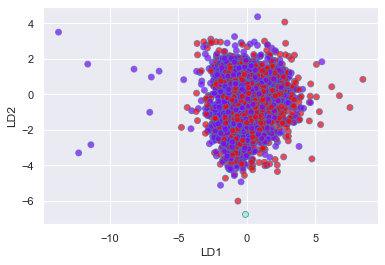

In [163]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_train_lda[:,0],
    X_train_lda[:,1],
    c=y_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [164]:
# Show the predictions
model = LinearDiscriminantAnalysis()
model = model.fit(X_train_lda, y_train)
lda_preds = model.predict(X_test_lda)
# predictions = model.predict_proba(X_test)

In [165]:
# Show the model metrics
print (classification_report(y_test, preds))
print ("Accuracy:","{:.2%}".format(accuracy_score(y_test, lda_preds)))
lda_tvp = class_signal_summary(y_test, lda_preds)
lda_tvp

              precision    recall  f1-score   support

          -1       0.55      0.44      0.49      1516
           0       0.00      0.00      0.00         1
           1       0.54      0.64      0.59      1573

    accuracy                           0.54      3090
   macro avg       0.36      0.36      0.36      3090
weighted avg       0.54      0.54      0.54      3090

Accuracy: 54.34%
 1    1853
-1    1231
 0       6
Name: Predictions, dtype: int64
Bullish Signals: 59.97%
Neutral Signals: 0.19%
Barish Signals: 39.84%


,Test Set,Predictions
DateTime,,
2020-01-30 15:00:00+00:00,1,1
2021-02-24 18:00:00+00:00,-1,1
2021-04-22 23:00:00+00:00,1,1
2020-09-30 06:00:00+00:00,1,1
2020-07-15 03:00:00+00:00,-1,1
...,...,...
2020-05-09 03:00:00+00:00,1,-1
2021-04-23 02:00:00+00:00,-1,-1
2020-06-06 06:00:00+00:00,-1,1


### PCA

In [166]:
# Principal Component Analysis (PCA)
# PCA selects the components which would result in the highest spread (retain the most information)
# n_components represents the number of gerated features from dimensionality reduction
pca = PCA(n_components=min(n_features, n_classes - 1))

# pca_model = pca.fit(X_train, y_train)
# X_train_pca = pca.fit_transform(X_train, y_train)
pca = pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_

array([0.77519737, 0.06888385])

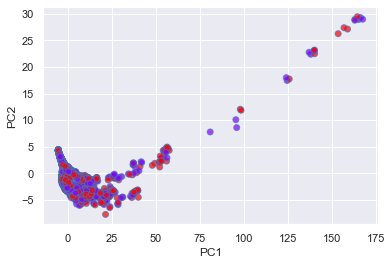

In [167]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_train_pca[:,0],
    X_train_pca[:,1],
    c=y_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [168]:
# Show the predictions
model = model.fit(X_train_pca, y_train)
pca_preds = model.predict(X_test_pca)
# predictions = model.predict_proba(X_test)


In [170]:
# Show the model metrics
from FiScrape.ml_tools import class_signal_summary
print (classification_report(y_test, preds))
print ("Accuracy:","{:.2%}".format(accuracy_score(y_test, pca_preds)))
pca_tvp = class_signal_summary(y_test, pca_preds)
pca_tvp

              precision    recall  f1-score   support

          -1       0.55      0.44      0.49      1516
           0       0.00      0.00      0.00         1
           1       0.54      0.64      0.59      1573

    accuracy                           0.54      3090
   macro avg       0.36      0.36      0.36      3090
weighted avg       0.54      0.54      0.54      3090

Accuracy: 50.91%
1    3090
Name: Predictions, dtype: int64
Bullish Signals: 100.00%
Neutral Signals: 0.00%
Barish Signals: 0.00%


,Test Set,Predictions
DateTime,,
2020-01-30 15:00:00+00:00,1,1
2021-02-24 18:00:00+00:00,-1,1
2021-04-22 23:00:00+00:00,1,1
2020-09-30 06:00:00+00:00,1,1
2020-07-15 03:00:00+00:00,-1,1
...,...,...
2020-05-09 03:00:00+00:00,1,1
2021-04-23 02:00:00+00:00,-1,1
2020-06-06 06:00:00+00:00,-1,1


# Trading

In [456]:
train_size = int(len(dset) * 0.8)
test_size = len(dset) - train_size
train_set, test_set = dset.iloc[0:train_size],dset.iloc[train_size:len(dset)]

In [457]:
# preds.shape[1]
try:
    if preds.shape[1] >0:
        test_set['Short'] = preds[:,1]
        test_set['Hold'] = preds[:,1]
        test_set['Long'] = preds[:,1]
except:
    test_set['Prediction'] = preds
    print (test_set['Prediction'].value_counts())

pd.set_option('display.float_format', lambda x: '%.6f' % x)
test_set
# test_set.rename(columns={'Open': 'open', 'High':'high', 'Low':'low', 'Close':'close'})

 1    1853
-1    1231
 0       6
Name: Prediction, dtype: int64


,Open,High,Low,Close,Volume,Year,Quarter,Month,Day_of_Week,Hour,...,target,Articles,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Current_Open,Prediction
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-22 01:00:00+00:00,37263.350000,37741.920000,36877.000000,37654.310000,5150.910109,2021.000000,2.000000,5.000000,5.000000,0.000000,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37652.420000,1
2021-05-22 02:00:00+00:00,37652.420000,37987.630000,37200.000000,37620.760000,4908.655250,2021.000000,2.000000,5.000000,5.000000,1.000000,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37620.750000,1
2021-05-22 03:00:00+00:00,37620.750000,38100.000000,37139.910000,37382.960000,5044.531754,2021.000000,2.000000,5.000000,5.000000,2.000000,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37382.970000,1
2021-05-22 04:00:00+00:00,37382.970000,37716.140000,36517.030000,36951.850000,8142.793950,2021.000000,2.000000,5.000000,5.000000,3.000000,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36947.310000,1
2021-05-22 05:00:00+00:00,36947.310000,37219.450000,35875.110000,36304.180000,7326.519005,2021.000000,2.000000,5.000000,5.000000,4.000000,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36304.190000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28 06:00:00+00:00,42634.840000,42722.300000,42347.200000,42413.060000,1495.189510,2021.000000,3.000000,9.000000,1.000000,5.000000,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42413.070000,-1
2021-09-28 07:00:00+00:00,42413.070000,42490.950000,41855.990000,42214.350000,1739.578560,2021.000000,3.000000,9.000000,1.000000,6.000000,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42214.350000,-1
2021-09-28 08:00:00+00:00,42214.350000,42303.340000,41650.000000,41775.250000,2331.773060,2021.000000,3.000000,9.000000,1.000000,7.000000,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41777.790000,1


In [252]:
# test_set['Open'] = test_set['Open']/10000
# test_set['High'] = test_set['High']/10000
# test_set['Low'] = test_set['Low']/10000
# test_set['Close'] = test_set['Close']/10000
# test_set['Predictions'] = test_set['Predictions'].replace(0, -1)
# test_set

# Backtesting Environment

In [458]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
import seaborn as sns
sns.set_style('darkgrid')

In [459]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Custom Commission Scheme

In [460]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', 0.00075),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

## DataFrame Loader

In [473]:
OHLCV = ['Open', 'High', 'Low', 'Close']

# class to define the columns we will provide
class SignalData(bt.feeds.PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['Current_Open'] + ['predicted']
    # cols = OHLCV + ['Current_Open'] + ['Short', 'Hold', 'Long']
        
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

## Strategy

In [474]:
class BasicClassifier(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.data_current_open = self.datas[0].Current_Open
        self.dataclose = self.datas[0].close
        self.data_predicted = self.datas[0].Prediction

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Current_Open, %.2f' % self.data_current_open[0])
        self.log('Close, %.2f' % self.dataclose[0])
        self.log('Prediction, %.2f' % self.data_predicted[0])

        if not self.position:
            if self.data_predicted > 0:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()
        elif self.data_predicted < 0: 
            self.close()

In [484]:
class ClassMLStrategy(bt.Strategy):
    """A basic one-step machine learning classification pipeline for either a portfolio or single security."""
    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] < 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] > 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

In [485]:
# class LMAStrategy(bt.Strategy):
 
#     def __init__(self):
#         ma_fast = bt.ind.SMA(period = 50)
#         ma_slow = bt.ind.SMA(period = 200)
         
#         self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
 
#     def next(self):
#         if not self.position:
#             if self.crossover > 0: 
#                 self.buy()
#         elif self.crossover < 0: 
#             self.close()

class LMAStrategy(bt.Strategy):
    """The contrarian version of the widely used, basic, SMA crossover CTA strategy, for either a portfolio or single security.
    Used here for comparison & illustrative purposes."""
 
    def __init__(self):
        ma_fast = bt.ind.SMA(period = 50)
        ma_slow = bt.ind.SMA(period = 200)
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        
    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if self.crossover[0] < 0:
                    up[data._name] = self.crossover[0]
                elif self.crossover[0] > 0:
                    down[data._name] = self.crossover[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

In [486]:
class SMAStrategy(bt.Strategy):
    """Simple Moving average crossover for either a portfolio or single security.
    Used here for comparison & illustrative purposes."""
 
    def __init__(self):
        ma_fast = bt.ind.SMA(period = 50)
        dataclose = self.datas[0].close
         
        self.crossover = bt.ind.CrossOver(ma_fast, dataclose)

    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if self.crossover[0] > 0:
                    up[data._name] = self.crossover[0]
                elif self.crossover[0] < 0:
                    down[data._name] = self.crossover[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

In [487]:
class ClassProbaMLStrategy(bt.Strategy):
    """A basic one-step machine learning classification pipeline, that takes classification probabilities as input, for either a portfolio or single security."""
    params = (('n_positions', 1),
              ('min_positions', 0),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        short = self.datas[0].Short
        hold = self.datas[0].Hold
        long = self.datas[0].Long
        for data in self.datas:
            if data.datetime.date() == today:
                if long < 0.51:
                    up[data._name] = long
                elif short > 0.51:
                    down[data._name] = short
                # elif long > hold:
                #     down[data._name] = long
                # elif short > hold:
                #     down[data._name] = short

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

## Create and Configure Cerebro Instance

In [488]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
start_nav = 1000000.0
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(start_nav)
print ("Opening NAV: ${:,.2f}".format(start_nav))

Opening NAV: $1,000,000.00


## Add input data

In [489]:
# # instantiate SignalData class
# data = SignalData(dataname=test_set)
# # instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
# cerebro = bt.Cerebro(stdstats = True, cheat_on_open=True)
# cerebro.addstrategy(Classifier)
# cerebro.adddata(data)
# cerebro.broker.setcash(10000000.0)
# cerebro.broker.setcommission(commission=0.02)
# cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# # run the backtest
# print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# backtest_result = cerebro.run()
# print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [490]:
# tickers = {'BTCUSDT': test_set}
tickers = {'BTCUSDT': test_set}

for ticker in tickers:
    bt_df = tickers[ticker]
    bt_df.index.name = 'datetime'
    if 'Prediction' in bt_df.columns:
        bt_df = bt_df.rename(columns={'Prediction':'predicted'})
    bt_data = SignalData(dataname=bt_df)
    cerebro.adddata(bt_data, name=ticker)

## Run Backtest

In [491]:
# cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# cerebro.addanalyzer(btanalyzers.Transactions, _name = "trans")
# cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
#                     verbose=True, log_file='bt_log.csv')
# start = time()
# results = cerebro.run()
# ending_value = cerebro.broker.getvalue()
# duration = time() - start
# n_trades = len(results[0].analyzers.trans.get_analysis()) 

# print ("Test Start:", bt_df.index.min())
# print ("Test End:", bt_df.index.max())
# test_dt_len = ((bt_df.index.max() - bt_df.index.min()).total_seconds())/(24*60*60)
# print (f"Days: {test_dt_len:,.2f}")

# print ("Opening NAV: ${:,.2f}".format(start_nav))
# print(f'Closing NAV ${ending_value:,.2f}')
# gross_ret = (ending_value/start_nav)-1
# print ("Gross Return: {:,.2%}".format(gross_ret))
# print(f'Duration: {format_time(duration)}')
# print(f'Trades: {n_trades:,}')

In [492]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(btanalyzers.Transactions, _name = "trans")
cerebro.addstrategy(ClassMLStrategy, n_positions=1, min_positions=0, 
                    verbose=True, log_file='bt_log.csv')
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start
n_trades = len(results[0].analyzers.trans.get_analysis()) 

print ("Test Start:", bt_df.index.min())
print ("Test End:", bt_df.index.max())
test_dt_len = ((bt_df.index.max() - bt_df.index.min()).total_seconds())/(24*60*60)
print (f"Days: {test_dt_len:,.2f}")

print ("Opening NAV: ${:,.2f}".format(start_nav))
print(f'Closing NAV ${ending_value:,.2f}')
gross_ret = (ending_value/start_nav)-1
print ("Gross Return: {:,.2%}".format(gross_ret))
print(f'Duration: {format_time(duration)}')
print(f'Trades: {n_trades:,}')

Test Start: 2021-05-22 01:00:00+00:00
Test End: 2021-09-28 10:00:00+00:00
Days: 129.38
Opening NAV: $1,000,000.00
Closing NAV $1,064,302.38
Gross Return: 6.43%
Duration: 00:00:03
Trades: 1,672


## Get pyfolio inputs

In [493]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [494]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [495]:
returns = returns[:-1]
returns

index
2021-05-22 00:00:00+00:00    0.003979
2021-05-23 00:00:00+00:00    0.222423
2021-05-24 00:00:00+00:00   -0.091830
2021-05-25 00:00:00+00:00   -0.024502
2021-05-26 00:00:00+00:00   -0.061115
                               ...   
2021-09-23 00:00:00+00:00   -0.057369
2021-09-24 00:00:00+00:00    0.018792
2021-09-25 00:00:00+00:00   -0.005524
2021-09-26 00:00:00+00:00   -0.005438
2021-09-27 00:00:00+00:00    0.014718
Name: return, Length: 129, dtype: float64

In [496]:
positions

,BTCUSDT,cash
Datetime,,
2021-05-22 00:00:00+00:00,978181.880000,25797.502000
2021-05-23 00:00:00+00:00,1217979.720000,9307.646500
2021-05-24 00:00:00+00:00,-1076023.200000,2190609.249500
2021-05-25 00:00:00+00:00,-1113745.000000,2201021.520750
2021-05-26 00:00:00+00:00,1012903.840000,7924.013500
...,...,...
2021-09-24 00:00:00+00:00,-1074828.250000,2177193.119250
2021-09-25 00:00:00+00:00,-1067934.250000,2164210.059750
2021-09-26 00:00:00+00:00,-1029467.760000,2119782.152500


In [497]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2021-05-22 02:00:00+00:00,-26,37652.420000,0,BTCUSDT,978962.920000
2021-05-22 05:00:00+00:00,-1,36947.310000,0,BTCUSDT,36947.310000
2021-05-22 06:00:00+00:00,-1,36304.190000,0,BTCUSDT,36304.190000
2021-05-22 07:00:00+00:00,56,36376.260000,0,BTCUSDT,-2037070.560000
2021-05-22 09:00:00+00:00,-56,36266.360000,0,BTCUSDT,2030916.160000
...,...,...,...,...,...
2021-09-28 02:00:00+00:00,50,42333.000000,0,BTCUSDT,-2116650.000000
2021-09-28 03:00:00+00:00,-50,42459.920000,0,BTCUSDT,2122996.000000
2021-09-28 07:00:00+00:00,50,42413.070000,0,BTCUSDT,-2120653.500000


In [498]:
gross_lev

index
2021-05-22 01:00:00+00:00    0.000000
2021-05-22 02:00:00+00:00   -0.977335
2021-05-22 03:00:00+00:00   -0.965195
2021-05-22 04:00:00+00:00   -0.943561
2021-05-22 05:00:00+00:00   -0.946428
                               ...   
2021-09-28 06:00:00+00:00   -0.981188
2021-09-28 07:00:00+00:00    0.981101
2021-09-28 08:00:00+00:00    0.980906
2021-09-28 09:00:00+00:00   -0.984006
2021-09-28 10:00:00+00:00    0.984025
Name: gross_lev, Length: 3090, dtype: float64

In [499]:
bench_name = 'CBBTCUSD' # 'SP500'
benchmark = web.DataReader(bench_name, 'fred', returns.index.min() - timedelta(days=1), returns.index.max()).squeeze()
benchmark = benchmark.pct_change()
benchmark.index = benchmark.index.tz_localize('UTC')
benchmark = benchmark[1:]
benchmark

DATE
2021-05-22 00:00:00+00:00   -0.001113
2021-05-23 00:00:00+00:00   -0.065696
2021-05-24 00:00:00+00:00    0.108730
2021-05-25 00:00:00+00:00   -0.009169
2021-05-26 00:00:00+00:00    0.021981
                               ...   
2021-09-23 00:00:00+00:00    0.030971
2021-09-24 00:00:00+00:00   -0.046245
2021-09-25 00:00:00+00:00   -0.003139
2021-09-26 00:00:00+00:00    0.010772
2021-09-27 00:00:00+00:00   -0.021499
Name: CBBTCUSD, Length: 129, dtype: float64

In [500]:
stats = [returns, positions, transactions, gross_lev]
for df in stats:
    df.drop(df[df.index > benchmark.index[-1]].index, inplace=True)
gross_lev

index
2021-05-22 01:00:00+00:00    0.000000
2021-05-22 02:00:00+00:00   -0.977335
2021-05-22 03:00:00+00:00   -0.965195
2021-05-22 04:00:00+00:00   -0.943561
2021-05-22 05:00:00+00:00   -0.946428
                               ...   
2021-09-26 20:00:00+00:00    0.996026
2021-09-26 21:00:00+00:00   -1.013869
2021-09-26 22:00:00+00:00    0.973270
2021-09-26 23:00:00+00:00   -0.944193
2021-09-27 00:00:00+00:00    0.983635
Name: gross_lev, Length: 3056, dtype: float64

In [501]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

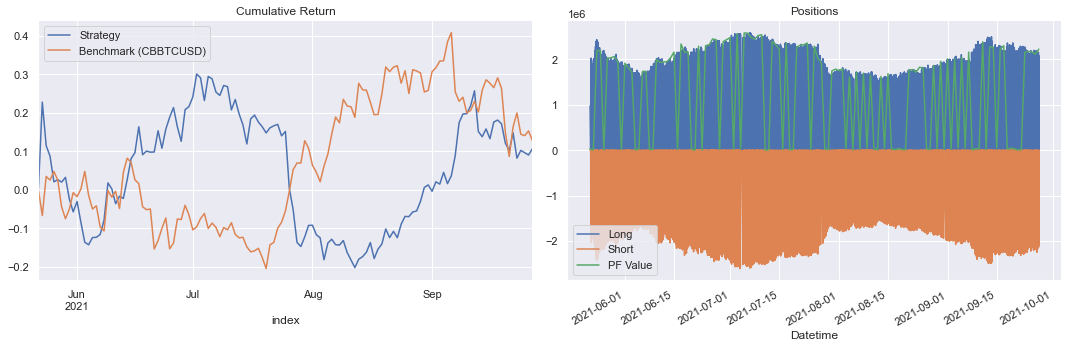

In [502]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame(f'Benchmark ({bench_name})'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2021-05-22
End date,2021-09-27
Total months,6
,Backtest
Annual return,21.829%
Cumulative returns,10.636%
Annual volatility,65.98%
Sharpe ratio,0.62
Calmar ratio,0.57
Stability,0.00
Max drawdown,-38.599%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.60,2021-07-02,2021-08-12,NaT,NaN
1,30.12,2021-05-23,2021-06-04,2021-07-01,29
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2021-09-27 00:00:00+0000', tz='UTC'))

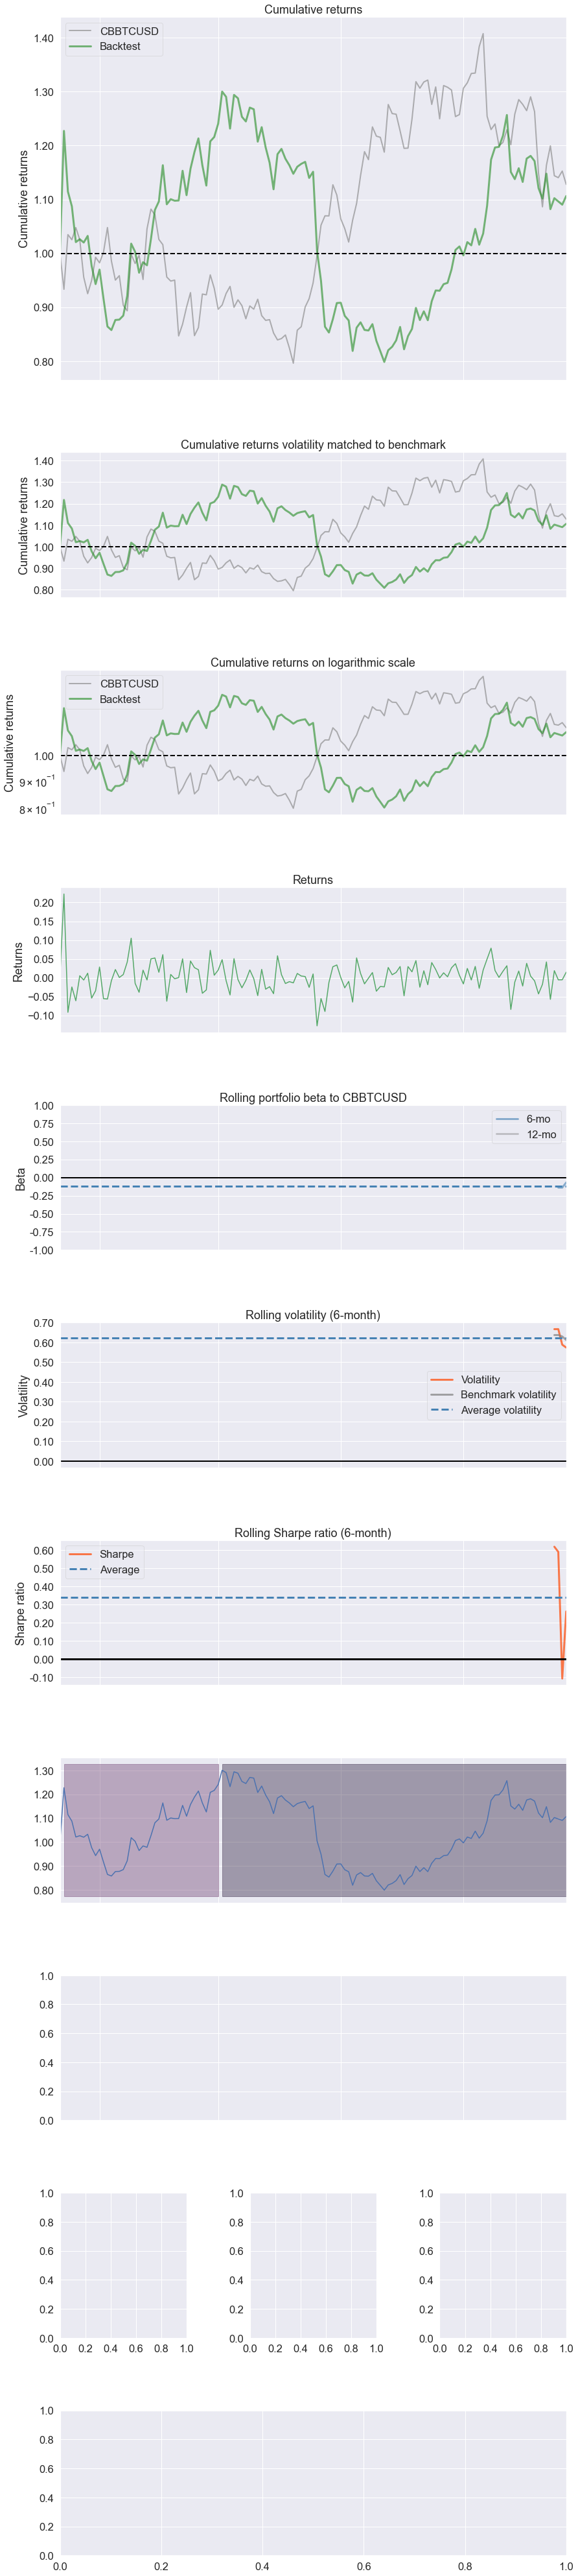

In [503]:
# This will throw an error if the portfolio balance ends in a drawdown. Need to fix it.
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark)

<AxesSubplot:title={'center':'Rolling portfolio beta to CBBTCUSD'}, ylabel='Beta'>

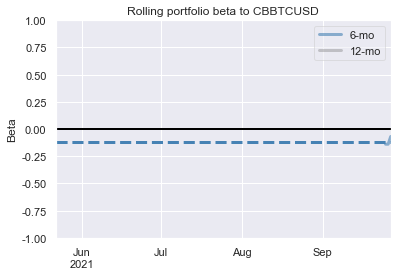

In [504]:
pf.plotting.plot_rolling_beta(returns, factor_returns=benchmark.dropna(),legend_loc='best',ax=None)

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

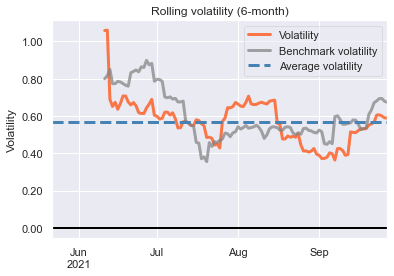

In [505]:
pf.plotting.plot_rolling_volatility(returns, factor_returns=benchmark.dropna(),
                            rolling_window=21,
                            legend_loc='best', ax=None)

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

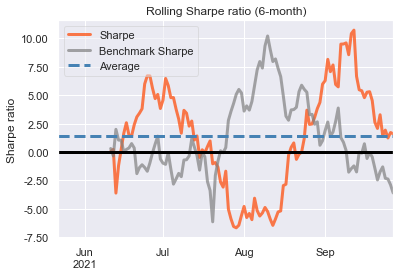

In [506]:
pf.plotting.plot_rolling_sharpe(returns, factor_returns=benchmark.dropna(),
                        rolling_window=21,
                        legend_loc='best', ax=None)

<AxesSubplot:title={'center':'Daily turnover'}, ylabel='Turnover'>

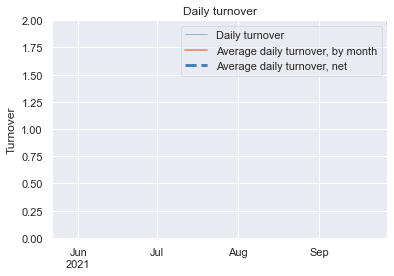

In [507]:
pf.plotting.plot_turnover(returns, transactions, positions, turnover_denom='AGB', # turnover_denom='portfolio_value',
                  legend_loc='best', ax=None)